In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import copy

from shapely import Point
from shapely import affinity, set_precision
from shapely.plotting import plot_points

#sys.path.insert(1, '/Users/neoh/Documents/git/eeroqlab/fabrication/')
sys.path.insert(1, '/Users/helium/Documents/git/eeroqlab/fabrication')
from zeroheliumkit.settings import *
from zeroheliumkit.helpers.plotting import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

GRID_SIZE = 1e-4

In [3]:
class Anchor():
    __slots__ = "point", "direction", "label"
    
    def __init__(self, point: Point | tuple=Point(), direction: float=0, label: str=None):
        if not isinstance(point, Point):
            coords = np.array(point).squeeze()
            self.point = Point(coords)
        else:
            self.point = point
        self.direction = direction
        self.label = label
    
    def rotate(self, angle: float, origin: tuple=(0,0)):
        """ Rotates the point by 'angle' around 'origin'"""
        point_upd = affinity.rotate(self.point, angle, origin)
        self.point = set_precision(point_upd, grid_size=GRID_SIZE)
        self.direction += angle
    
    def move(self, xoff: float=0, yoff: float=0):
        point_upd = affinity.translate(self.point, xoff=xoff, yoff=yoff)
        self.point = set_precision(point_upd, grid_size=GRID_SIZE)
    
    def scale(self, xfact: float=1.0, yfact: float=1.0, origin: tuple=(0,0)):
        point_upd = affinity.scale(self.point, xfact=xfact, yfact=yfact, origin=origin)
        self.point = set_precision(point_upd, grid_size=GRID_SIZE)
        if yfact < 0:
            #rotation around x-axis
            self.direction = (-1) * self.direction
        
        if xfact < 0:
            #rotation around y_axis
            self.direction = 180 - self.direction

    def mirror(self, aroundaxis: str=None, update_label: str=None):
        if aroundaxis=='x':
            self.scale(1, -1)
        elif aroundaxis=='y':
            self.scale(-1, 1)
        elif aroundaxis not in ['x', 'y', None]:
            raise ValueError("choose 'x', 'y or None for mirror arguments")
        
        if aroundaxis and update_label:
            self.label = update_label
    
    def plot(self, ax=None, color: str=None):
        if ax is None:
            ax = default_ax()
        
        coords = (self.point.x, self.point.y)

        x1, x2 = ax.get_xlim()
        y1, y2 = ax.get_ylim()
        arrow_length = min(np.abs(x2-x1), np.abs(y2-y1)) * 0.08
        arrow_kwargs = dict(arrowstyle='->', linewidth=2, color=RED)
        ax.annotate('', 
                    xy=(coords[0] + arrow_length*np.cos(self.direction*np.pi/180), coords[1] + arrow_length*np.sin(self.direction*np.pi/180)), 
                    xytext=(coords[0], coords[1]), 
                    arrowprops=arrow_kwargs)
        ax.annotate(self.label,
                    coords,
                    color=BLACK,
                    clip_on=True, 
                    bbox=dict(facecolor='white', edgecolor=color, boxstyle='round', alpha=0.7))
        ax.plot(coords[0], coords[1], linestyle="", marker=".", color=color, alpha=1, zorder=1e9)

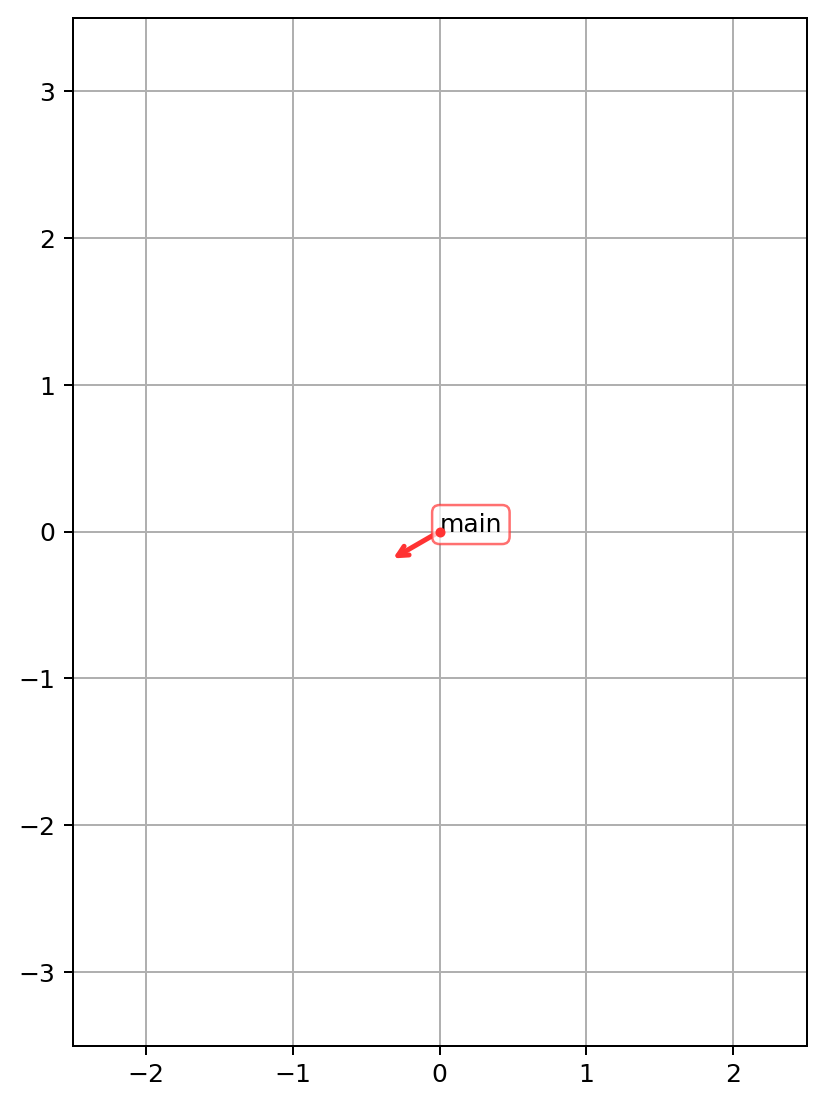

In [4]:
p = Anchor((0,0), 10, "main")
p.rotate(920)


fig = plt.figure(1, figsize=SIZE_L, dpi=90)
ax = fig.add_subplot(111)
set_limits(ax=ax, coor=(0,0), dxdy=[5, 7])

p.plot(ax=ax, color=RED)

plt.grid()
plt.gca().set_aspect('equal')
plt.show()


In [21]:
class MultiAnchor():
    __slots__ = "multipoint"
    
    def __init__(self, multipoint: list=[]):
        self.multipoint = multipoint
    
    def copy(self):
        """ Returns  deepcopy of the class """
        return copy.deepcopy(self.multipoint)

    def rotate(self, angle: float, origin: tuple=(0,0)):
        for p in self.multipoint:
            p.rotate(angle, origin)
    
    def move(self, xoff: float=0, yoff: float=0):
        for p in self.multipoint:
            p.move(xoff, yoff)

    def scale(self, xfact: float=1.0, yfact: float=1.0, origin: tuple=(0,0)):
        for p in self.multipoint:
            p.scale(xfact, yfact, origin)
    
    def mirror(self, aroundaxis: str=None, update_labels: bool=False, keep_original: bool=False):
        if not keep_original:
            if not update_labels:
                for p in self.multipoint:
                    p.mirror(aroundaxis)
            else:
                for p in self.multipoint:
                    p.mirror(aroundaxis, p.label + "_m")
        else:
            original = self.copy()
            for p in self.multipoint:
                    p.mirror(aroundaxis, p.label + "_m")
            self.multipoint = self.multipoint + original

       
    def __point(self, label: str):
        label_list = [p.label for p in self.multipoint]
        idx = label_list.index(label)
        return self.multipoint[idx]

    def point(self, labels: list[str]):
        if type(labels) is list:
            return [self.__point(l) for l in labels]
        else:
            return self.__point(labels)
    
    def remove(self, labels: list | str):
        if isinstance(labels, str):
            labels = [labels]
        S1 = set(self.point(labels))
        S2 = set(self.multipoint)
        self.multipoint = S2.difference(S1)


    def plot(self, ax=None, color: str=None):
        for p in self.multipoint:
            p.plot(ax=ax, color=color)

In [ ]:
points = []
num = 5
for i in range(num):
    x = np.cos(i/num*np.pi)
    y = np.sin(i/num*np.pi)
    points.append(Anchor((x,y), -45, f"abc{i}"))
mp = MultiAnchor(points)
#mp.rotate(90)
mp.scale(4, 1)
mp.mirror(aroundaxis="x", keep_original=True)
mp.remove("abc1")
mp.remove(["abc2", "abc3", "abc4"])


fig = plt.figure(1, figsize=SIZE_L, dpi=90)
ax = fig.add_subplot(111)
set_limits(ax=ax, coor=(0,0), dxdy=[10, 10])

mp.plot(ax=ax, color=RED)

plt.grid()
plt.gca().set_aspect('equal')
plt.show()

In [14]:
L1 = [1,2,3,4,5,6,7,8,9]
L2 = [1,2,9,8,15]

S1 = set(L1)
S2 = set(L2)
print(S1.intersection(S2))
print(S1.difference(S2))

{8, 1, 2, 9}
{3, 4, 5, 6, 7}
